In [3]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,LSTM
import datetime as dt
plt.rcParams['figure.dpi'] = 300

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Machine Learning Models for Stream Discharge Prediction

Author: Ekaterina M. D. Lezine

---

#### Specify which station:

Options are: 'indin', 'hanbury', 'hay', 'snare'

In [4]:
station = 'snare'

---

#### Data Preperation:

Note: I prepared the data for both ERA5 and weather, but did not use the weather data because it was missing so many dates and the results were atrocious.

In [5]:
train = pd.read_csv(station + '_train.csv')
valid = pd.read_csv(station + '_valid.csv')
test = pd.read_csv(station + '_test.csv')
holdout = pd.read_csv(station + '_holdout.csv')

##### ERA5:

Training:

In [6]:
train_era5 = train

#Add 1,2,3 lag day variables for precipitation:
era5_tp = train_era5['era5_noon_tp'].values
era5_tp_1daylag = np.zeros(len(era5_tp))
era5_tp_1daylag[:] = np.nan
era5_tp_1daylag[1:,] = era5_tp[:-1]
train_era5['era5_tp_1daylag'] = era5_tp_1daylag

era5_tp_2daylag = np.zeros(len(era5_tp))
era5_tp_2daylag[:] = np.nan
era5_tp_2daylag[2:,] = era5_tp[:-2]
train_era5['era5_tp_2daylag'] = era5_tp_2daylag

era5_tp_3daylag = np.zeros(len(era5_tp))
era5_tp_3daylag[:] = np.nan
era5_tp_3daylag[3:,] = era5_tp[:-3]
train_era5['era5_tp_3daylag'] = era5_tp_3daylag

#Get rid of any rows with no data:
train_era5 = train_era5[train_era5['flow'].notna()]
train_era5 = train_era5[train_era5['era5_tp_1daylag'].notna()]
train_era5 = train_era5[train_era5['era5_tp_2daylag'].notna()]
train_era5 = train_era5[train_era5['era5_tp_3daylag'].notna()]

#Add a day of year variable:
train_era5 = train_era5.sort_values(by="datetime")
train_era5['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in train_era5.datetime]

Validation:

In [7]:
valid_era5 = valid

era5_tp = valid_era5['era5_noon_tp'].values
era5_tp_1daylag = np.zeros(len(era5_tp))
era5_tp_1daylag[:] = np.nan
era5_tp_1daylag[1:,] = era5_tp[:-1]
valid_era5['era5_tp_1daylag'] = era5_tp_1daylag

era5_tp_2daylag = np.zeros(len(era5_tp))
era5_tp_2daylag[:] = np.nan
era5_tp_2daylag[2:,] = era5_tp[:-2]
valid_era5['era5_tp_2daylag'] = era5_tp_2daylag

era5_tp_3daylag = np.zeros(len(era5_tp))
era5_tp_3daylag[:] = np.nan
era5_tp_3daylag[3:,] = era5_tp[:-3]
valid_era5['era5_tp_3daylag'] = era5_tp_3daylag

valid_era5 = valid_era5[valid_era5['flow'].notna()]
valid_era5 = valid_era5[valid_era5['era5_tp_1daylag'].notna()]
valid_era5 = valid_era5[valid_era5['era5_tp_2daylag'].notna()]
valid_era5 = valid_era5[valid_era5['era5_tp_3daylag'].notna()]

valid_era5 = valid_era5.sort_values(by="datetime")
valid_era5['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in valid_era5.datetime]

Test:

In [8]:
test_era5 = test

era5_tp = test_era5['era5_noon_tp'].values
era5_tp_1daylag = np.zeros(len(era5_tp))
era5_tp_1daylag[:] = np.nan
era5_tp_1daylag[1:,] = era5_tp[:-1]
test_era5['era5_tp_1daylag'] = era5_tp_1daylag

era5_tp_2daylag = np.zeros(len(era5_tp))
era5_tp_2daylag[:] = np.nan
era5_tp_2daylag[2:,] = era5_tp[:-2]
test_era5['era5_tp_2daylag'] = era5_tp_2daylag

era5_tp_3daylag = np.zeros(len(era5_tp))
era5_tp_3daylag[:] = np.nan
era5_tp_3daylag[3:,] = era5_tp[:-3]
test_era5['era5_tp_3daylag'] = era5_tp_3daylag

test_era5 = test_era5[test_era5['flow'].notna()]
test_era5 = test_era5[test_era5['era5_tp_1daylag'].notna()]
test_era5 = test_era5[test_era5['era5_tp_2daylag'].notna()]
test_era5 = test_era5[test_era5['era5_tp_3daylag'].notna()]

test_era5 = test_era5.sort_values(by="datetime")
test_era5['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in test_era5.datetime]

Holdout:

In [9]:
holdout_era5 = holdout

era5_tp = holdout_era5['era5_noon_tp'].values
era5_tp_1daylag = np.zeros(len(era5_tp))
era5_tp_1daylag[:] = np.nan
era5_tp_1daylag[1:,] = era5_tp[:-1]
holdout_era5['era5_tp_1daylag'] = era5_tp_1daylag

era5_tp_2daylag = np.zeros(len(era5_tp))
era5_tp_2daylag[:] = np.nan
era5_tp_2daylag[2:,] = era5_tp[:-2]
holdout_era5['era5_tp_2daylag'] = era5_tp_2daylag

era5_tp_3daylag = np.zeros(len(era5_tp))
era5_tp_3daylag[:] = np.nan
era5_tp_3daylag[3:,] = era5_tp[:-3]
holdout_era5['era5_tp_3daylag'] = era5_tp_3daylag

holdout_era5 = holdout_era5[holdout_era5['flow'].notna()]
holdout_era5 = holdout_era5[holdout_era5['era5_tp_1daylag'].notna()]
holdout_era5 = holdout_era5[holdout_era5['era5_tp_2daylag'].notna()]
holdout_era5 = holdout_era5[holdout_era5['era5_tp_3daylag'].notna()]

holdout_era5 = holdout_era5.sort_values(by="datetime")
holdout_era5['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in holdout_era5.datetime]

##### Weather Station:

Training:

In [10]:
train_w = train

#Get rid of any rows with no data:
train_w = train_w[train_w['flow'].notna()]
train_w = train_w[train_w['st_max_temp'].notna()]
train_w = train_w[train_w['st_min_temp'].notna()]
train_w = train_w[train_w['st_mean_temp'].notna()]
train_w = train_w[train_w['st_total_precip'].notna()]

#Add a day of year variable:
train_w = train_w.sort_values(by="datetime")
train_w['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in train_w.datetime]

Validation:

In [11]:
valid_w = valid

#Get rid of any rows with no data:
valid_w = valid_w[valid_w['flow'].notna()]
valid_w = valid_w[valid_w['st_max_temp'].notna()]
valid_w = valid_w[valid_w['st_min_temp'].notna()]
valid_w = valid_w[valid_w['st_mean_temp'].notna()]
valid_w = valid_w[valid_w['st_total_precip'].notna()]

#Add a day of year variable:
valid_w = valid_w.sort_values(by="datetime")
valid_w['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in valid_w.datetime]

Test:

In [12]:
test_w = test

#Get rid of any rows with no data:
test_w = test_w[test_w['flow'].notna()]
test_w = test_w[test_w['st_max_temp'].notna()]
test_w = test_w[test_w['st_min_temp'].notna()]
test_w = test_w[test_w['st_mean_temp'].notna()]
test_w = test_w[test_w['st_total_precip'].notna()]

#Add a day of year variable:
test_w = test_w.sort_values(by="datetime")
test_w['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in test_w.datetime]

Holdout:

In [13]:
holdout_w = holdout

#Get rid of any rows with no data:
holdout_w = holdout_w[holdout_w['flow'].notna()]
holdout_w = holdout_w[holdout_w['st_max_temp'].notna()]
holdout_w = holdout_w[holdout_w['st_min_temp'].notna()]
holdout_w = holdout_w[holdout_w['st_mean_temp'].notna()]
holdout_w = holdout_w[holdout_w['st_total_precip'].notna()]

#Add a day of year variable:
holdout_w = holdout_w.sort_values(by="datetime")
holdout_w['doy'] = [dt.datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in holdout_w.datetime]

---

#### Split data:

##### ERA5

In [14]:
y_train_era5 = np.asarray(train_era5.flow.values)
x_train_era5  = pd.concat([train_era5.doy, train_era5.era5_tp_1daylag, train_era5.era5_tp_2daylag, train_era5.era5_tp_3daylag, train_era5.era5_noon_t2m, train_era5.era5_noon_evavt, train_era5.era5_noon_ro, train_era5.era5_noon_sd, train_era5.era5_noon_es, train_era5.era5_noon_sf, train_era5.era5_noon_smlt, train_era5.era5_noon_stl1, train_era5.era5_noon_ssr, train_era5.era5_noon_e, train_era5.era5_noon_tp], axis=1)

y_test_era5 = np.asarray(test_era5.flow.values)
x_test_era5 = pd.concat([test_era5.doy, test_era5.era5_tp_1daylag, test_era5.era5_tp_2daylag, test_era5.era5_tp_3daylag, test_era5.era5_noon_t2m, test_era5.era5_noon_evavt, test_era5.era5_noon_ro, test_era5.era5_noon_sd, test_era5.era5_noon_es, test_era5.era5_noon_sf, test_era5.era5_noon_smlt, test_era5.era5_noon_stl1, test_era5.era5_noon_ssr, test_era5.era5_noon_e, test_era5.era5_noon_tp], axis=1)

y_valid_era5 = np.asarray(valid_era5.flow.values)
x_valid_era5 = pd.concat([valid_era5.doy, valid_era5.era5_tp_1daylag, valid_era5.era5_tp_2daylag, valid_era5.era5_tp_3daylag, valid_era5.era5_noon_t2m, valid_era5.era5_noon_evavt, valid_era5.era5_noon_ro, valid_era5.era5_noon_sd, valid_era5.era5_noon_es, valid_era5.era5_noon_sf, valid_era5.era5_noon_smlt, valid_era5.era5_noon_stl1, valid_era5.era5_noon_ssr, valid_era5.era5_noon_e, valid_era5.era5_noon_tp], axis=1)

y_holdout_era5 = np.asarray(holdout_era5.flow.values)
x_holdout_era5 = pd.concat([holdout_era5.doy, holdout_era5.era5_tp_1daylag, holdout_era5.era5_tp_2daylag, holdout_era5.era5_tp_3daylag, holdout_era5.era5_noon_t2m, holdout_era5.era5_noon_evavt, holdout_era5.era5_noon_ro, holdout_era5.era5_noon_sd, holdout_era5.era5_noon_es, holdout_era5.era5_noon_sf, holdout_era5.era5_noon_smlt, holdout_era5.era5_noon_stl1, holdout_era5.era5_noon_ssr, holdout_era5.era5_noon_e, holdout_era5.era5_noon_tp], axis=1)

Scale the data:

In [15]:
scaler = MinMaxScaler()  
x = pd.concat([x_train_era5, x_test_era5, x_valid_era5, x_holdout_era5])
x_scaled = scaler.fit(x).transform(x)

x_train_era5 = x_scaled[0:len(x_train_era5)]
x_test_era5 = x_scaled[len(x_train_era5):len(x_train_era5)+len(x_test_era5)]
x_valid_era5 = x_scaled[len(x_train_era5)+len(x_test_era5):len(x_train_era5)+len(x_test_era5)+len(x_valid_era5)]
x_holdout_era5 = x_scaled[len(x_train_era5)+len(x_test_era5)+len(x_valid_era5):]

##### Weather

In [16]:
y_train_w = np.asarray(train_w.flow.values)
x_train_w  = pd.concat([train_w.doy, train_w.st_max_temp, train_w.st_min_temp, train_w.st_mean_temp, train_w.st_total_precip], axis = 1) 
                        
y_test_w = np.asarray(test_w.flow.values)
x_test_w  = pd.concat([test_w.doy, test_w.st_max_temp, test_w.st_min_temp, test_w.st_mean_temp, test_w.st_total_precip], axis = 1) 
  
y_valid_w = np.asarray(valid_w.flow.values)
x_valid_w  = pd.concat([valid_w.doy, valid_w.st_max_temp, valid_w.st_min_temp, valid_w.st_mean_temp, valid_w.st_total_precip], axis = 1) 
  
y_holdout_w = np.asarray(holdout_w.flow.values)
x_holdout_w  = pd.concat([holdout_w.doy, holdout_w.st_max_temp, holdout_w.st_min_temp, holdout_w.st_mean_temp, holdout_w.st_total_precip], axis = 1) 

Scale the data:

In [17]:
scaler = MinMaxScaler()  
x = pd.concat([x_train_w, x_test_w, x_valid_w, x_holdout_w])
x_scaled = scaler.fit(x).transform(x)

x_train_w = x_scaled[0:len(x_train_w)]
x_test_w = x_scaled[len(x_train_w):len(x_train_w)+len(x_test_w)]
x_valid_w = x_scaled[len(x_train_w)+len(x_test_w):len(x_train_w)+len(x_test_w)+len(x_valid_w)]
x_holdout_w = x_scaled[len(x_train_w)+len(x_test_w)+len(x_valid_w):]

---

### Training and Testing Models:

#### Multi Layer Perceptron

Define the MLP:

Finding the optimal Adam learning rate and hidden layer size:

In [18]:
val_r2 = []

#Nodes and batch sizes to try across 300 epochs:
lrs = np.array([0.1,0.01,0.001,0.0001])
hiddens = np.arange(100,1000,200)

for lr in lrs:
    for hidden in hiddens:
        
        classifier_era5 = MLPRegressor(solver = 'adam', alpha = lr, hidden_layer_sizes=(hidden,), random_state=1, max_iter=100000)

        classifier_era5.fit(x_train_era5, y_train_era5)
        
        predictions_valid_era5 = classifier_era5.predict(x_valid_era5)
        
        from sklearn.metrics import r2_score

        r2_era5 = r2_score(y_valid_era5, predictions_valid_era5)

        val_r2.append(r2_era5)

combos = []
lr_list = []
hidden_list = []
for lr in lrs:
    for hidden in hiddens:
        lr_list.append(lr)
        hidden_list.append(hidden)
        combos.append([lr, hidden])

#Create a CSV of all the R2s at all the different combos to save:
df = pd.DataFrame(columns = ['LR', 'Hidden_Layer_Size', 'Val_R2'])
df.LR = lr_list
df.Hidden_Layer_Size = hidden_list
df.Val_R2 = val_r2
df.to_csv(station + '_ERA5_MLP_R2.csv')

#Finding the minimum trianing loss across all combos:
max_r2 = max(val_r2)

best_combo = combos[np.argmax(val_r2)]

print('Best combo is ' + str(best_combo) + ' with an r2 of ' + str(max_r2))

Best combo is [0.01, 900] with an r2 of 0.41028551896401877


In [19]:
#Training best model:

lr = best_combo[0]
hidden = best_combo[1]

classifier_era5 = MLPRegressor(solver='adam', alpha=lr, hidden_layer_sizes=(hidden,), random_state=1, max_iter=100000)
classifier_era5.fit(x_train_era5, y_train_era5)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(900,), max_iter=100000,
             random_state=1)

Predict discharge for test, valid, and holdout:

In [20]:
predictions_test_era5 = classifier_era5.predict(x_test_era5)
predictions_holdout_era5 = classifier_era5.predict(x_holdout_era5)
predictions_valid_era5 = classifier_era5.predict(x_valid_era5)

Plot the results:

Text(0.5, 0, 'Timestep')

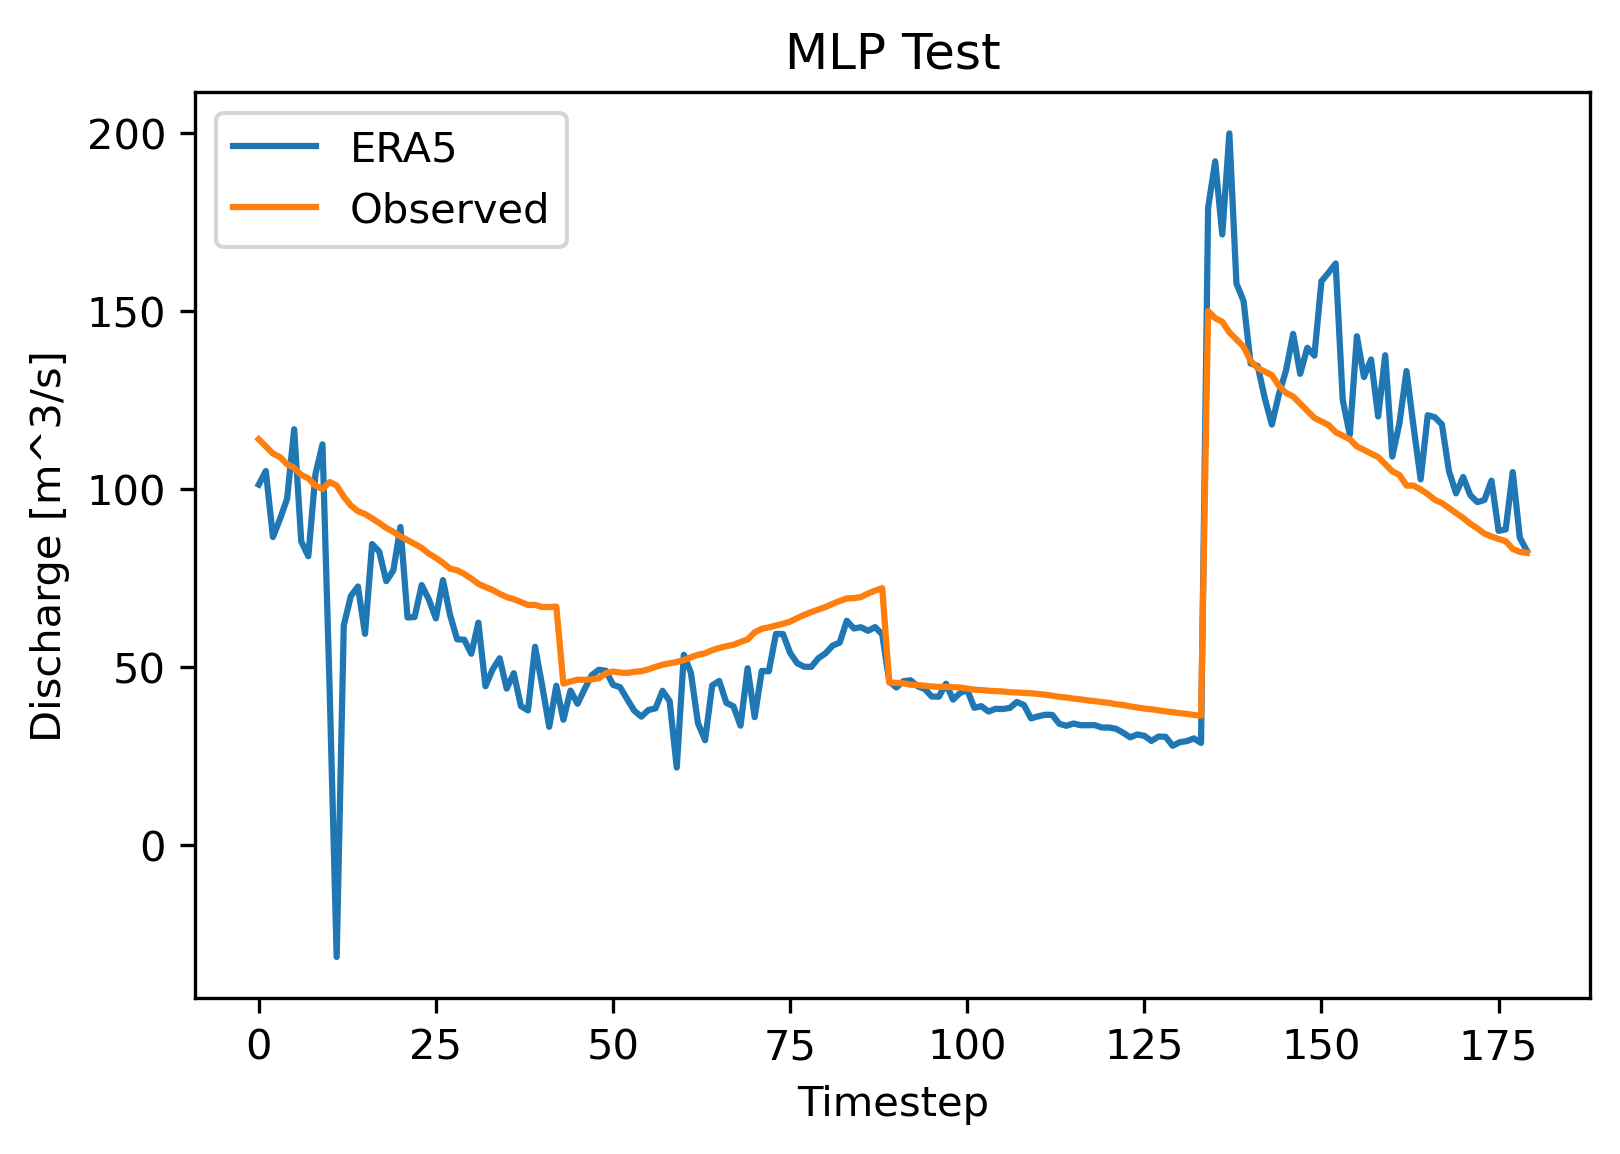

In [21]:
plt.plot(predictions_test_era5, label='ERA5')
plt.plot(y_test_era5, label='Observed')
plt.legend()
plt.title('MLP Test')
plt.ylabel('Discharge [m^3/s]')
plt.xlabel('Timestep')

Error metrics:

In [22]:
from sklearn.metrics import r2_score

r2_era5 = r2_score(y_test_era5, predictions_test_era5)
print('R2 ERA5:', r2_era5)

# RMSE, MAE, NSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_era5 = mean_squared_error(y_test_era5, predictions_test_era5, squared=False)
mae_era5 = mean_absolute_error(y_test_era5, predictions_test_era5)

denom = np.sum((y_test_era5 - np.mean(y_test_era5)) ** 2)
num_era5 = np.sum((predictions_test_era5 - y_test_era5) ** 2)
nse_era5 = 1 - num_era5/denom
nnse_era5 = 1/(2-nse_era5)

print("RMSE ERA5:",rmse_era5)
print("MAE ERA5:", mae_era5)
print("NSE ERA5:", nse_era5)
print("NNSE ERA5:", nnse_era5)

R2 ERA5: 0.5933598933187062
RMSE ERA5: 19.228968582884164
MAE ERA5: 13.383636962519368
NSE ERA5: 0.5933598933187062
NNSE ERA5: 0.7109138970587966


Save the result for the holdout year:

In [23]:
np.save(station + '_mlp_holdout.npy', predictions_holdout_era5)

---

### LSTM

In [24]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

Reshaping the datasets into the correct shape for the network:

In [25]:
#Size is (len of the dates, number of features, 1)
x_train_era5 = x_train_era5.reshape(len(x_train_era5),15,1)
y_train_era5 = y_train_era5.reshape(len(y_train_era5),1,1)

x_valid_era5 = x_valid_era5.reshape(len(x_valid_era5),15,1)
x_test_era5 = x_test_era5.reshape(len(x_test_era5),15,1)
x_holdout_era5 = x_holdout_era5.reshape(len(x_holdout_era5),15,1)

Finding optimal number of nodes, batch size, and epochs:

In [26]:
train_losses = []
val_losses = []

#Nodes and batch sizes to try across 100 epochs:
nodes = np.array([1,100,200,300])
batch_size = np.array([1,25,50,100])

for node in nodes:
    for batch in batch_size:
        
        #Create the LSTM:
        model = Sequential()
        model.add(LSTM(node)) #variable nodes
        model.add(Dense(1)) #Dense layer
        model.compile(loss='mean_absolute_error', optimizer='adam') #using MAE and Adam with default LR 0.001
        
        #Fitting the model with the training data, validating with validation data, and variable batch size:
        hist = model.fit(x_train_era5, y_train_era5, epochs=100, batch_size=batch, verbose=0, validation_data = (x_valid_era5, y_valid_era5))
        
        #Add the training and validation losses from the above model to our above lists:
        train_losses.append(hist.history['loss'])
        val_losses.append(hist.history['val_loss'])

#Making a list of the node/batch size combinations to reference:
combos = []
node_list = []
batch_list = []
for node in nodes:
    for batch in batch_size:
        node_list.append(node)
        batch_list.append(batch)
        combos.append([node, batch])

#Create a CSV of all the losses at all the different node/batch size combos to save:
df = pd.DataFrame(columns = ['Nodes', 'Batch_Size', 'Train_Loss', 'Val_Loss'])
df.Nodes = node_list
df.Batch_Size = batch_list
df.Train_Loss = train_losses
df.Val_Loss = val_losses
df.to_csv(station + '_ERA5_LSTM_losses.csv')

#Finding the minimum trianing loss across all combos:
mins = []
for val in val_losses:
    mins.append(min(val))

best_combo = combos[np.argmin(mins)]
best_epochs = np.argmin(val_losses[np.argmin(mins)])

print('Best combo is ' + str(best_combo) + ' with ' + str(best_epochs) + ' epochs.')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmprse3bj8t.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmprse3bj8t.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Best combo is [100, 1] with 65 epochs.


Example plot of training losses:

In [ ]:
plt.plot(val_losses[0], label = 'Nodes: 1, Batch Size: 1', c = 'darkblue')
plt.plot(val_losses[5], label = 'Nodes: 100, Batch Size: 25', c = 'royalblue')
plt.plot(val_losses[10], label = 'Nodes: 200, Batch Size: 50', c = 'slateblue')
plt.plot(val_losses[-1], label = 'Nodes: 300, Batch Size: 100', c = 'steelblue')
plt.plot(val_losses[12], label = 'Nodes: 300, Batch Size: 1', c = 'red')
plt.title('LSTM Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')
plt.legend()

Using the best model to predict the test, validation, and holdout datasets:

In [27]:
#Training best model:

nodes = best_combo[0]
batches = best_combo[1]
epochs = best_epochs

model = Sequential()
model.add(LSTM(nodes)) #best # of nodes
model.add(Dense(1)) #Dense layer
model.compile(loss='mean_absolute_error', optimizer='adam') #using MAE and Adam with default LR 0.001
model.fit(x_train_era5, y_train_era5, epochs=epochs, batch_size=batches, verbose=0, validation_data = (x_valid_era5, y_valid_era5))      

In [28]:
#Use the trained model
predictions_test_era5 = model.predict(x_test_era5)
predictions_holdout_era5 = model.predict(x_holdout_era5)
predictions_valid_era5 = model.predict(x_valid_era5)

Text(0.5, 0, 'Timestep')

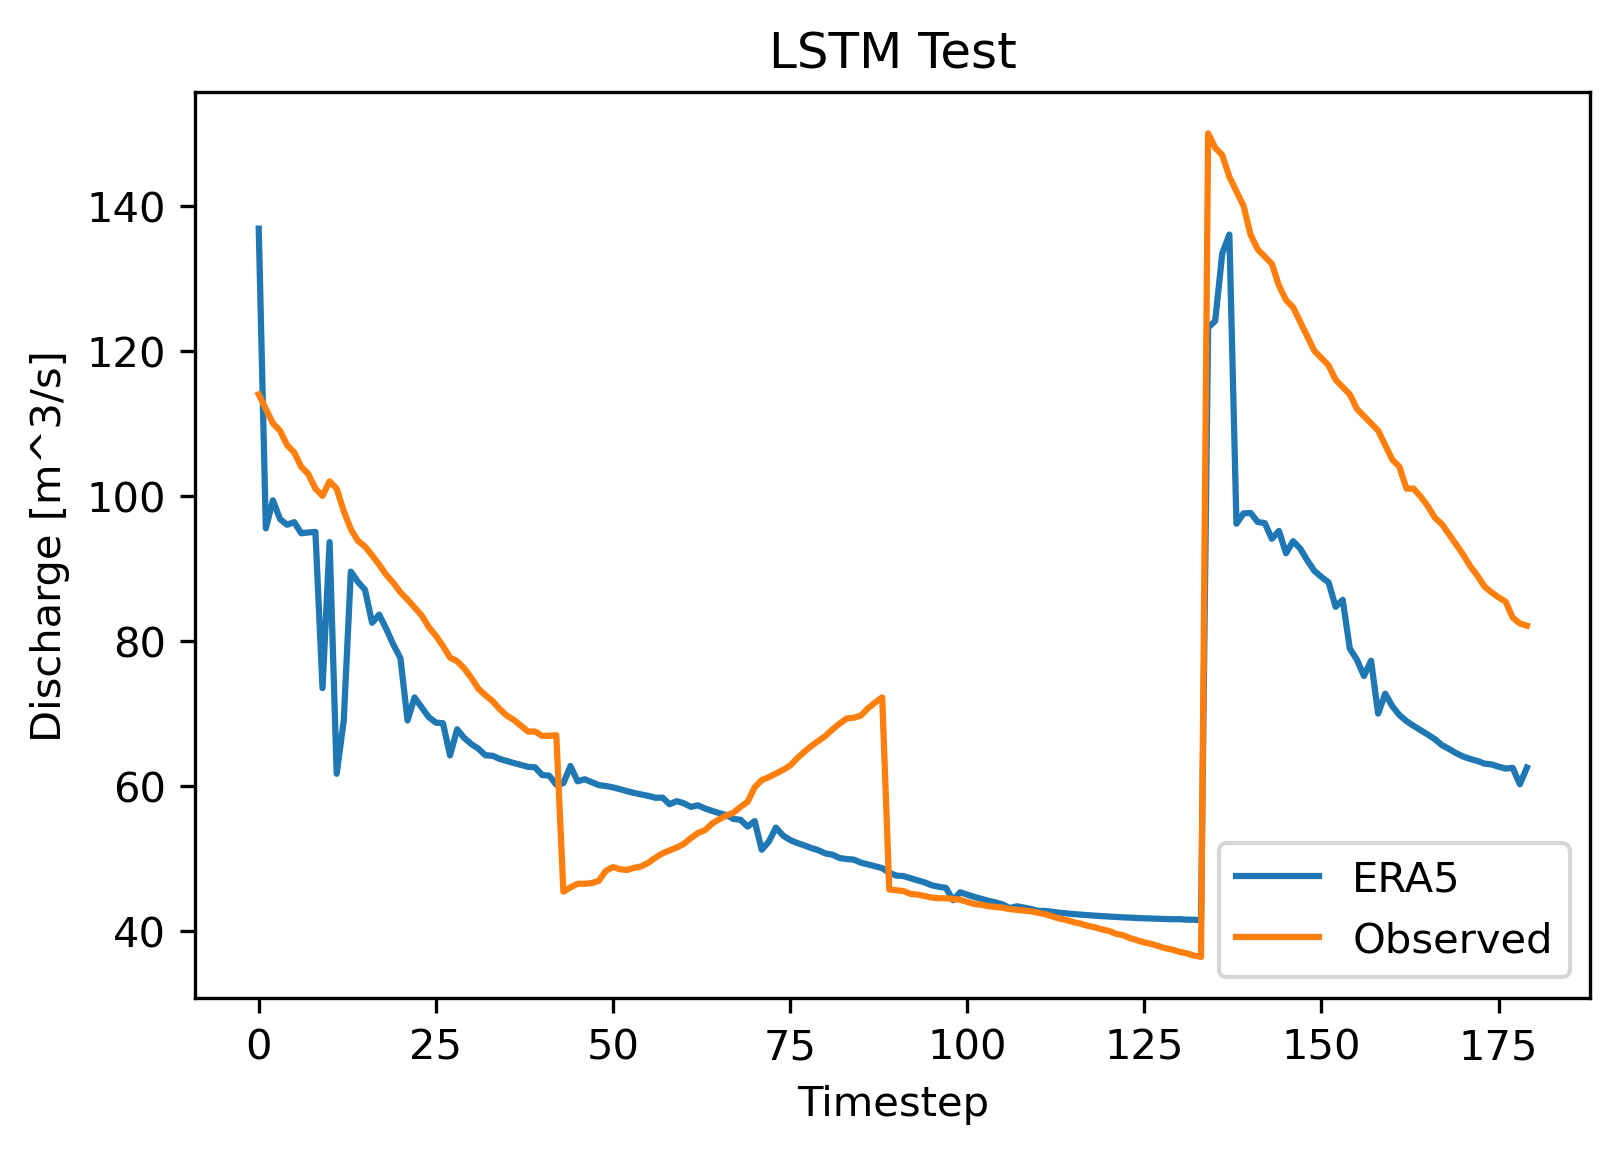

In [29]:
plt.plot(predictions_test_era5, label='ERA5')
plt.plot(y_test_era5, label='Observed')
plt.legend()
plt.title('LSTM Test')
plt.ylabel('Discharge [m^3/s]')
plt.xlabel('Timestep')

Error metrics:

In [30]:
from sklearn.metrics import r2_score

r2_era5 = r2_score(y_test_era5, predictions_test_era5)
print('R2 ERA5:', r2_era5)

# RMSE, MAE, NSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_era5 = mean_squared_error(y_test_era5, predictions_test_era5, squared=False)
mae_era5 = mean_absolute_error(y_test_era5, predictions_test_era5)

denom = np.sum((y_test_era5 - np.mean(y_test_era5)) ** 2)
num_era5 = np.sum((predictions_test_era5 - y_test_era5) ** 2)
nse_era5 = 1 - num_era5/denom
nnse_era5 = 1/(2-nse_era5)

print("RMSE ERA5:",rmse_era5)
print("MAE ERA5:", mae_era5)
print("NSE ERA5:", nse_era5)
print("NNSE ERA5:", nnse_era5)

R2 ERA5: 0.6420523410190899
RMSE ERA5: 18.041001713654047
MAE ERA5: 13.532567778693307
NSE ERA5: -278.71390598437046
NNSE ERA5: 0.0035623457858039915


Save the result for the holdout year:

In [31]:
np.save(station + '_lstm_holdout.npy', predictions_holdout_era5)